<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/04_03_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poetry generation challenge

This notebook serves as a challenge on how to create poetry like Shakespeare by leveraging RNNs(LSTMs). We'll be using the Shakerpeare poetry as the training data and then use the trained network to predict the next words.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2023-08-24 14:52:24.166170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:52:26.692301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:52:26.712746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 14:52:33.190910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.13.0


## Step 1: Create a corpus

In [2]:
##download data from this url
!wget --no-check-certificate \
    https://raw.githubusercontent.com/dswh/lil_nlp_with_tensorflow/main/sonnets.txt \
    -O /tmp/sonnet.txt

--2023-08-24 14:52:51--  https://raw.githubusercontent.com/dswh/lil_nlp_with_tensorflow/main/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29658 (29K) [text/plain]
Saving to: ‘/tmp/sonnet.txt’

/tmp/sonnet.txt     100%[===================>]  28.96K  --.-KB/s    in 0.002s  

2023-08-24 14:52:52 (14.7 MB/s) - ‘/tmp/sonnet.txt’ saved [29658/29658]



In [3]:
##printing the text
shakespeare_text = open('/tmp/sonnet.txt').read()
print(len(shakespeare_text))

28893


In [4]:
##create corpus by lowering the letters and splitting the text by \n
corpus = shakespeare_text.lower().split("\n")

## Set up the tokenizer

In [5]:
##set up tokenizer
tokenizer = Tokenizer()

In [10]:
tokenizer.fit_on_texts(corpus)

##calculate vocabulary size - be mindful of the <oov> token
vocab_size = len(tokenizer.word_index) + 1

# print(tokenizer.word_index)
# print(vocab_size)

In [11]:
##create sequences of 
input_sequences = []
for line in corpus:
    tokens = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(tokens)):
        n_gram_sequence = tokens[:i+1]
        input_sequences.append(n_gram_sequence)


In [23]:
##pad sequences
max_seq_len = max([len(i) for i in input_sequences])
input_seq_array = np.array(pad_sequences(input_sequences,
                                         maxlen=max_seq_len,
                                         padding='pre')
                        )


In [24]:
##creating features(X) and label(y)
X = input_seq_array[:, :-1]
labels = input_seq_array[:, -1]

##one-hot encode the labels to get y - since it is actually just a classification problem
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

## Define the LSTM model

In [26]:
model = tf.keras.Sequential([
                tf.keras.layers.Embedding(vocab_size, 120, input_length=max_seq_len-1),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120)),
                tf.keras.layers.Dense(vocab_size, activation='softmax')
])

##define the learning rate - step size for optimizer
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10


2023-08-24 15:02:28.464436: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27952576 exceeds 10% of free system memory.


142/142 [==============================] - 8s 35ms/step - loss: 6.7063 - accuracy: 0.0186
Epoch 2/10
142/142 [==============================] - 55s 388ms/step - loss: 6.0922 - accuracy: 0.0342
Epoch 3/10
142/142 [==============================] - 5s 36ms/step - loss: 5.4196 - accuracy: 0.0652
Epoch 4/10
142/142 [==============================] - 5s 33ms/step - loss: 4.4077 - accuracy: 0.1376
Epoch 5/10
142/142 [==============================] - 5s 36ms/step - loss: 3.1376 - accuracy: 0.3146
Epoch 6/10
142/142 [==============================] - 5s 34ms/step - loss: 2.0567 - accuracy: 0.5283
Epoch 7/10
142/142 [==============================] - 5s 35ms/step - loss: 1.3409 - accuracy: 0.6880
Epoch 8/10
142/142 [==============================] - 5s 35ms/step - loss: 0.8871 - accuracy: 0.7998
Epoch 9/10
142/142 [==============================] - 5s 33ms/step - loss: 0.6682 - accuracy: 0.8440
Epoch 10/10
142/142 [==============================] - 5s 35ms/step - loss: 0.5419 - accuracy: 0.869

## Visualise the metrics

In [27]:
import matplotlib.pyplot as plt


def plot_metric(history, metric):
  plt.plot(history.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

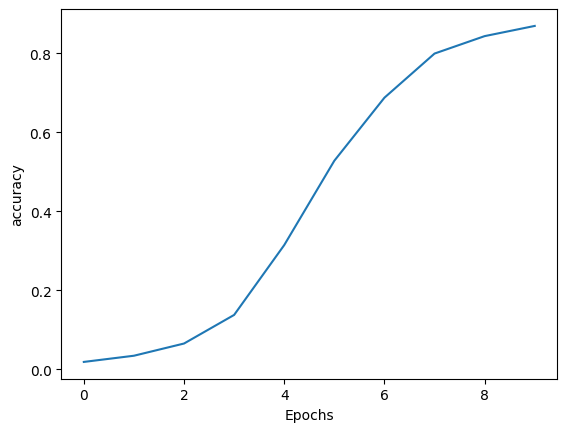

In [28]:
plot_metric(history, 'accuracy')

## Generate new text

In [32]:
seed_text = "my name is "
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list, verbose=0))
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

my name is  fortune and ransom all ill deeds of thy self thy
